<a href="https://colab.research.google.com/github/medayoubaziz1993/Titanic_data_set/blob/main/Titanic_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [40]:
pd.set_option('display.max_rows',None)
from sklearn import set_config
set_config(transform_output='pandas')


# Functions used

In [41]:
def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax


In [42]:
def explore_num(inspection_df, x, figsize=(7.5, 5)):
    temp_df = inspection_df.copy()
    null_count = temp_df[x].isna().sum()
    null_per = null_count * 100 / len(temp_df)
    nunique = temp_df[x].nunique()
    most_common_value = temp_df[x].value_counts(dropna=False).index[0]
    freq = temp_df[x].value_counts(dropna=False).values[0]
    per_common_value = freq * 100 / len(temp_df)

    gridspec = {'height_ratios': [0.7, 0.3]}
    fig, ax = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw=gridspec)

    sns.histplot(data=temp_df, x=x, ax=ax[0])
    sns.boxplot(data=temp_df, x=x, ax=ax[1])

    ax[0].set_title(f"Column: {x}", fontweight='bold', fontsize=15)
    sns.despine()
    fig.tight_layout()
    plt.show()

    print(f'There are {null_count} NaN ({round(null_per, 2)}%)')
    print(f'There are {nunique} unique values')
    print(f'The most common value is {most_common_value}, occurs {freq} times ({round(per_common_value, 2)}%)')

    if per_common_value > 98:
        print(f'{x}: is a constant or quasi-constant feature and should be dropped')
    else:
        print(f'{x}: is neither constant nor a quasi-constant feature and should be kept')

    return fig, ax


In [43]:
def plot_cat_vs_target(inspection_df , x , y='rating' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax


In [44]:
def plot_num_vs_target(inspection_df ,x,y='rating' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax


# Upload the data from kaggle.com

In [45]:
file_path1 = '/content/test[1].csv'
file_path2 = '/content/train[1].csv'
train = pd.read_csv(file_path2)
test = pd.read_csv(file_path1)


# Data discovery

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
name_ticket_cabin = ['Name','Ticket','Cabin']
num_cols = train.drop("PassengerId",axis=1).select_dtypes(include='number').columns
cat_cols = train.drop(name_ticket_cabin,axis=1).select_dtypes(include='object').columns

In [49]:
train[num_cols].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data Analysis

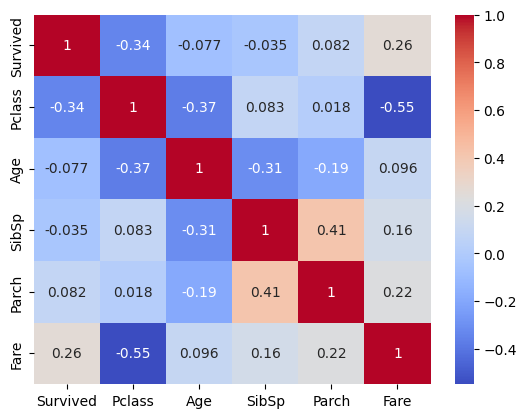

In [50]:
corr = train[num_cols].corr()
sns.heatmap(corr, cmap = 'coolwarm', annot = True)
plt.show()

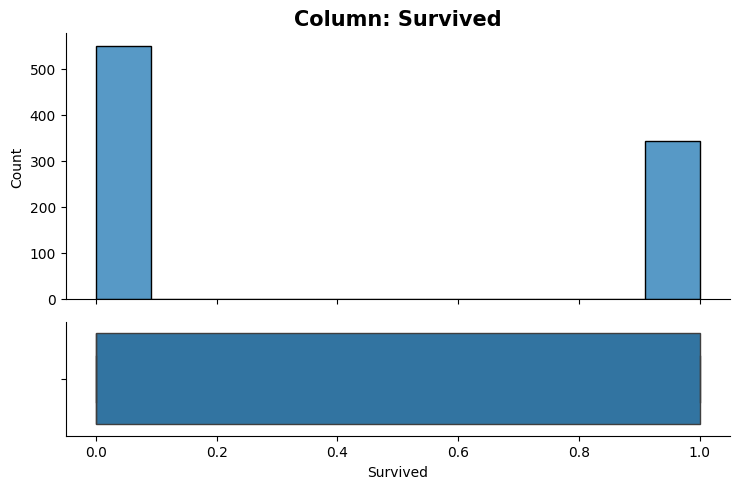

There are 0 NaN (0.0%)
There are 2 unique values
The most common value is 0, occurs 549 times (61.62%)
Survived: is neither constant nor a quasi-constant feature and should be kept


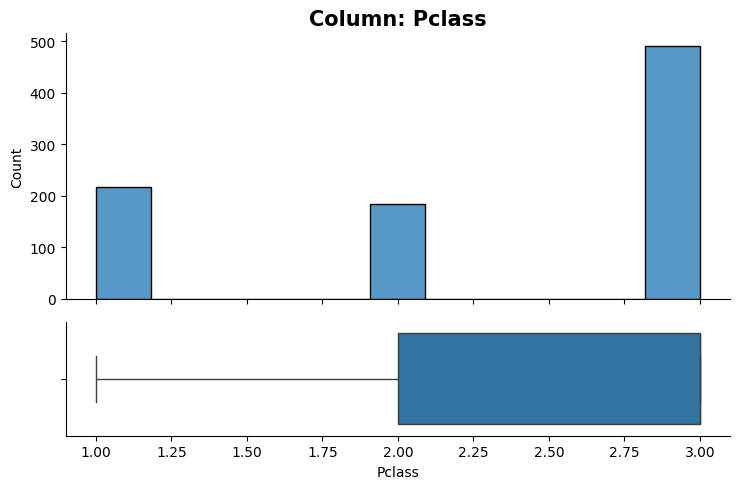

There are 0 NaN (0.0%)
There are 3 unique values
The most common value is 3, occurs 491 times (55.11%)
Pclass: is neither constant nor a quasi-constant feature and should be kept


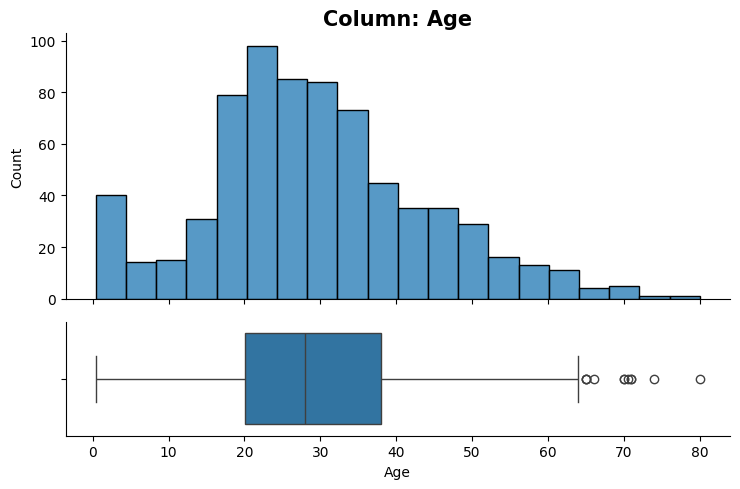

There are 177 NaN (19.87%)
There are 88 unique values
The most common value is nan, occurs 177 times (19.87%)
Age: is neither constant nor a quasi-constant feature and should be kept


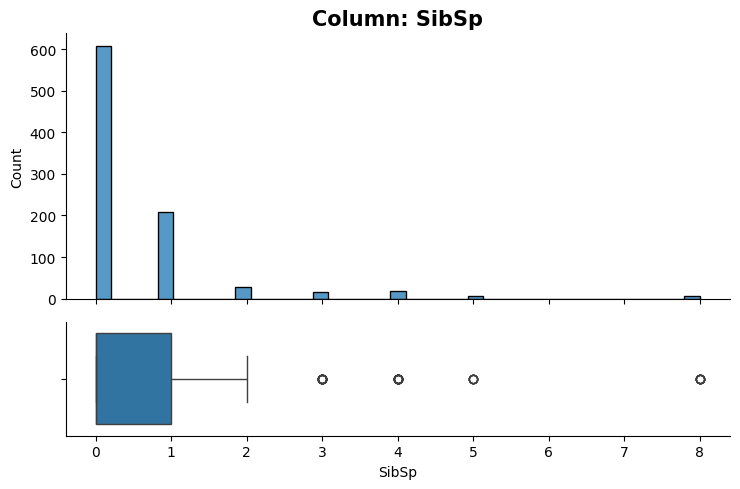

There are 0 NaN (0.0%)
There are 7 unique values
The most common value is 0, occurs 608 times (68.24%)
SibSp: is neither constant nor a quasi-constant feature and should be kept


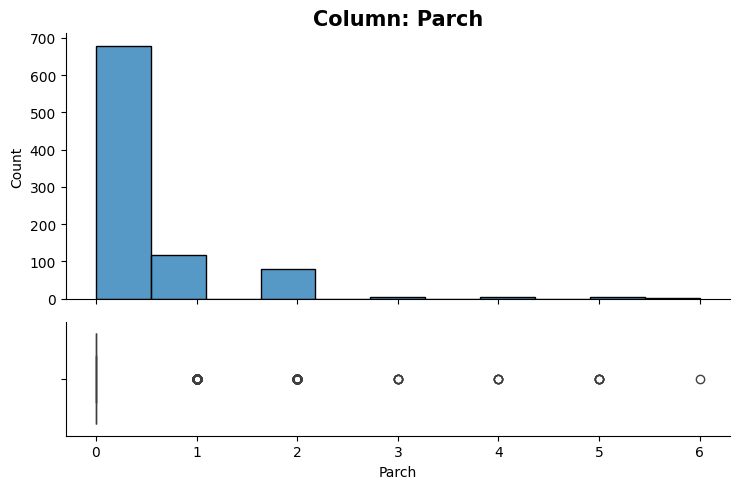

There are 0 NaN (0.0%)
There are 7 unique values
The most common value is 0, occurs 678 times (76.09%)
Parch: is neither constant nor a quasi-constant feature and should be kept


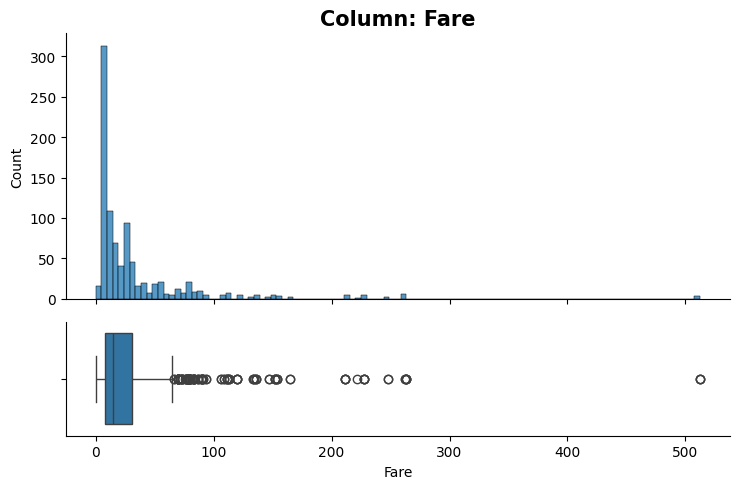

There are 0 NaN (0.0%)
There are 248 unique values
The most common value is 8.05, occurs 43 times (4.83%)
Fare: is neither constant nor a quasi-constant feature and should be kept


In [51]:
for i in num_cols :
  explore_num(train,i);

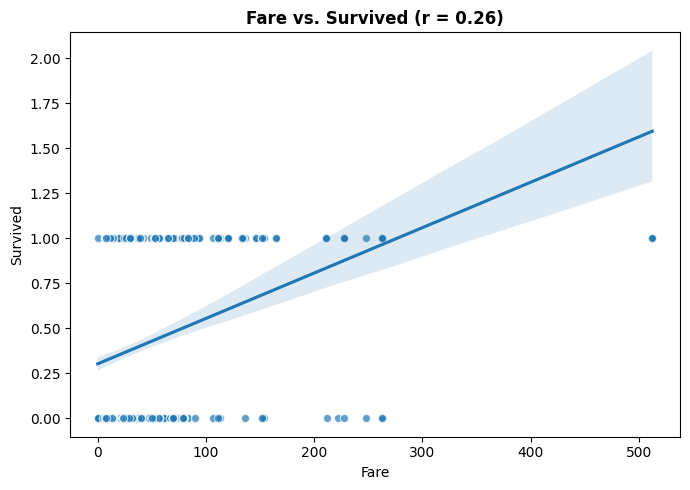

In [52]:
plot_num_vs_target(train,'Fare',y='Survived');

<ipython-input-41-e586939b7f9e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')


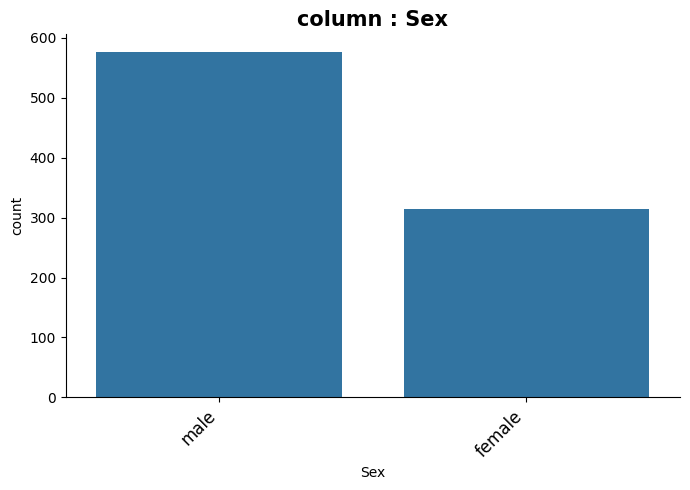

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is male , occurs 577 times (64.76%)
Sex: is neither constant or a quasi-constant feauture and should be kept


<ipython-input-41-e586939b7f9e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')


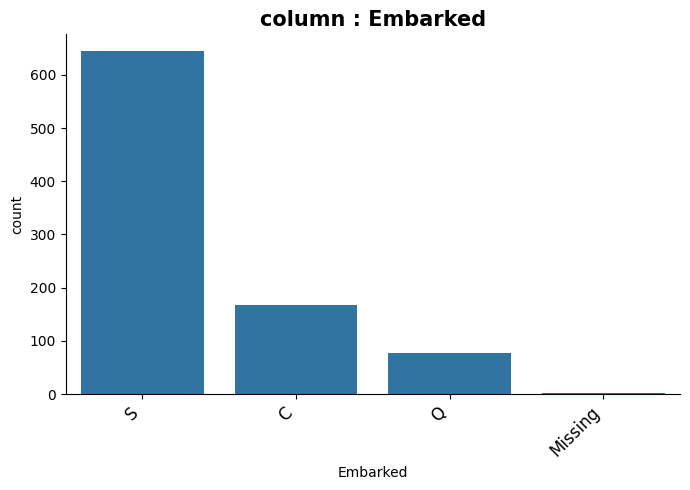

There is 2 NaN (0.22%)
There is 4 unique values
The most common value is S , occurs 644 times (72.28%)
Embarked: is neither constant or a quasi-constant feauture and should be kept


In [53]:
for i in cat_cols :
  explore_cat(train,i);

<ipython-input-43-db2b3c25e97c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)


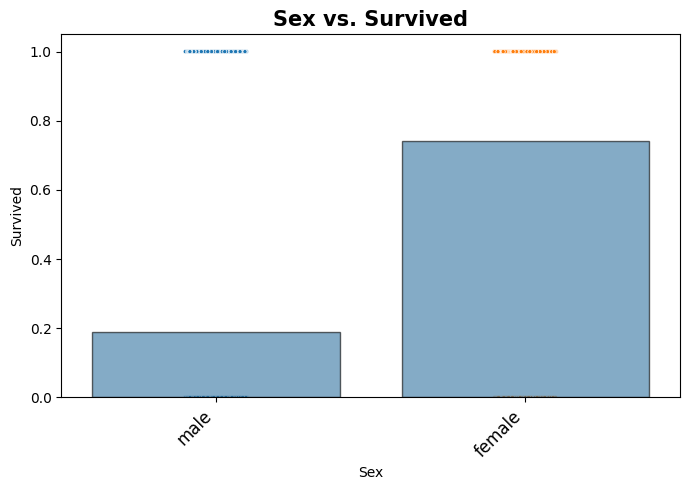

In [54]:
plot_cat_vs_target(train,'Sex',y='Survived');

In [55]:
for i in name_ticket_cabin :
  res = train[i].value_counts()
  print(res)
  print('-'*50)

Name
Braund, Mr. Owen Harris                                                               1
Boulos, Mr. Hanna                                                                     1
Frolicher-Stehli, Mr. Maxmillian                                                      1
Gilinski, Mr. Eliezer                                                                 1
Murdlin, Mr. Joseph                                                                   1
Rintamaki, Mr. Matti                                                                  1
Stephenson, Mrs. Walter Bertram (Martha Eustis)                                       1
Elsbury, Mr. William James                                                            1
Bourke, Miss. Mary                                                                    1
Chapman, Mr. John Henry                                                               1
Van Impe, Mr. Jean Baptiste                                                           1
Leitch, Miss. Jessie Wills 

In [56]:
train1= train.copy()

In [57]:
train1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From what we learn we have some columns that are going to create a lot of noise to the model so i want to drop them , such as : Name , Ticket and Cabin .

The column 'Cabin' is super useful but it has only 22% from the 891 entries .

We aslo proven that the children and females are the first to rescue .

For the missing data , we have the column 'Age' that i'm going to impute with the mean since the distribution of the data is almost normalized but for the column 'Embarked' i'll use the mode or the most frequent since we have only two missing data so it's safer .

In [58]:
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
# We will drop the unecessery columns but first let's check them .
# Function to extract first two numbers
def extract_first_two_numbers(ticket):
    numbers = re.findall(r'\d', ticket)
    return ''.join(numbers[:2]) if numbers else None

# Function to extract first two letters
def extract_first_two_letters(ticket):
    letters = re.findall(r'[A-Za-z]', ticket)
    return ''.join(letters[:2]) if letters else None




In [59]:
# Create new columns
train1['ticket_num'] = train1['Ticket'].apply(extract_first_two_numbers)
train1['ticket_cat'] = train1['Ticket'].apply(extract_first_two_letters)
train1['ticket_num'] = pd.to_numeric(train1['ticket_num'], errors='coerce')

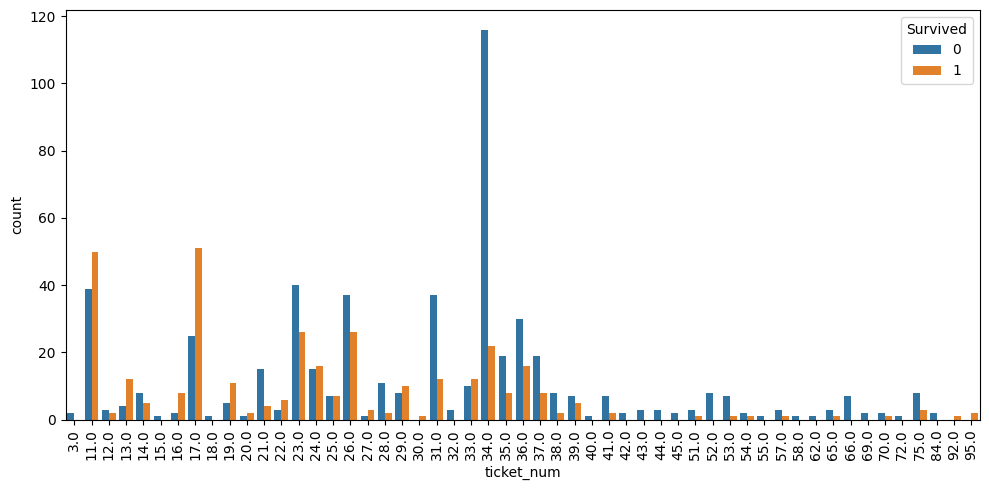

In [60]:
fig,ax = plt.subplots(figsize=(10,5))
sns.countplot(data=train1, x='ticket_num',hue='Survived')
plt.xticks(rotation=90)
plt.tight_layout()


<ipython-input-43-db2b3c25e97c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)


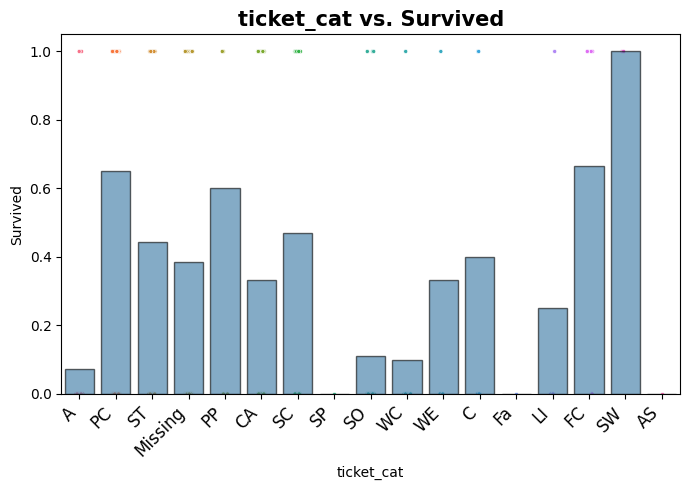

In [61]:
plot_cat_vs_target(train1,'ticket_cat',y='Survived');

# Data Engineering

In [62]:
train2 = train.copy()
train2.drop(columns=name_ticket_cabin,inplace=True)

In [63]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [64]:
train2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [65]:
train2['Sex'] = train2['Sex'].replace({'male': 0, 'female': 1})
train2['Embarked'] = train2['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})

In [66]:
train3 = train2.copy()
train3 = train3.drop(columns='PassengerId')

In [67]:
train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [68]:
train3.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0.0
1,1,1,1,38.0,1,0,71.2833,1.0
2,1,3,1,26.0,0,0,7.9250,0.0
3,1,1,1,35.0,1,0,53.1000,0.0
4,0,3,0,35.0,0,0,8.0500,0.0


In [69]:
cat_col = ['Embarked','Sex']
num_col = ['Age', 'Pclass', 'SibSp','Parch','Fare']
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'))
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
transformer = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col)
],verbose_feature_names_out=False)

In [70]:
X_train = train3.drop(columns='Survived')
y_train = train3['Survived']
X_train_tr = transformer.fit_transform(X_train)

In [71]:
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       891 non-null    float64
 1   Pclass    891 non-null    float64
 2   SibSp     891 non-null    float64
 3   Parch     891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    float64
 6   Sex       891 non-null    float64
dtypes: float64(7)
memory usage: 48.9 KB


In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [73]:
col2drop = ['PassengerId','Name','Ticket','Cabin']
test1 = test.drop(columns=col2drop)
test1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [74]:
X_test = transformer.transform(test1)

In [75]:
X_test['Sex'] = X_test['Sex'].replace({'male': 0, 'female': 1})
X_test['Embarked'] = X_test['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})

# Modeling

In [76]:
model1 = LogisticRegression()
model1.fit(X_train_tr,y_train)

LogisticRegression()

In [77]:
model2 = DecisionTreeClassifier()
model2.fit(X_train_tr,y_train)

DecisionTreeClassifier()

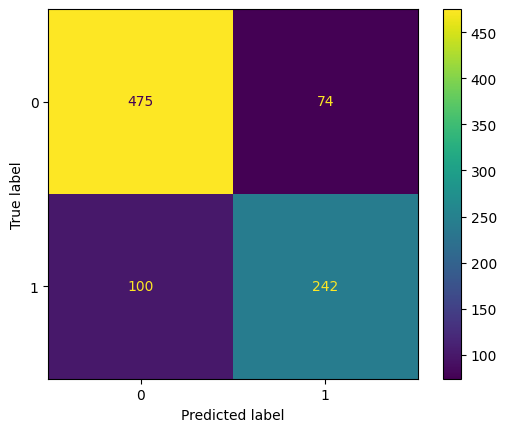

In [78]:
ConfusionMatrixDisplay.from_estimator(model1,X_train_tr,y_train)

In [79]:
print(classification_report(y_train,model1.predict(X_train_tr)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.77      0.71      0.74       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



In [80]:
logistic_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
logistic_grid_search = GridSearchCV(estimator=model1, param_grid=logistic_param_grid, cv=5, scoring='accuracy')
logistic_grid_search.fit(X_train_tr, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [81]:
best_model1 = logistic_grid_search.best_estimator_


In [82]:
print(classification_report(y_train, best_model1.predict(X_train_tr)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.77      0.71      0.74       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



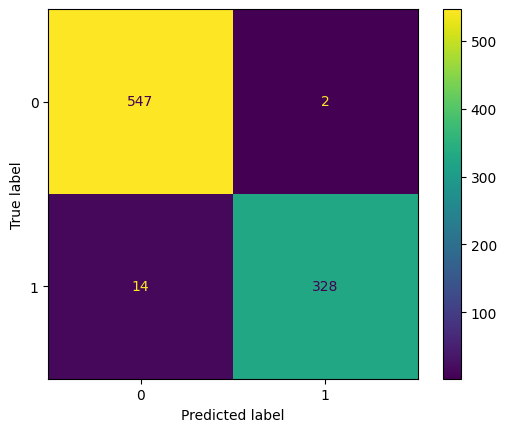

In [83]:
ConfusionMatrixDisplay.from_estimator(model2,X_train_tr,y_train)

In [84]:
print(classification_report(y_train,model2.predict(X_train_tr)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       549
           1       0.99      0.96      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



In [85]:
tree_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
tree_grid_search = GridSearchCV(estimator=model2, param_grid=tree_param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X_train_tr, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [86]:
best_model2 = tree_grid_search.best_estimator_
print(classification_report(y_train, best_model2.predict(X_train_tr)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       549
           1       0.92      0.78      0.84       342

    accuracy                           0.89       891
   macro avg       0.90      0.87      0.88       891
weighted avg       0.89      0.89      0.89       891



I choose to work with two models :

LogisticRegression , DecisionTreeClassifier

from only the training set the two models were good but the decision tree classifier was better

Even after tuning the two models with grid search cv the DecisionTreeClassifier was better and it shows in the submissions

In [87]:
model1_predictions = best_model1.predict(X_test)
model2_predictions = best_model2.predict(X_test)

In [88]:
submission1 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': model1_predictions
})

submission2 = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': model2_predictions
})

In [89]:
submission1.to_csv('submission1.csv', index=False)
submission2.to_csv('submission2.csv', index=False)

The first model (LogisticRegression) had a score of 0.76315


The second model scored 0.75837 in the titanic competition from kaggle.com